# Experiment Results Analysis & Comparison

This notebook provides a comprehensive analysis of all fine-tuning experiments:

**Models Compared:**
- **M0 (Baseline)**: Pre-trained CLIP without fine-tuning
- **M1 (LoRA)**: CLIP with Low-Rank Adaptation
- **M2 (QLoRA)**: CLIP with Quantized Low-Rank Adaptation (4-bit NF4)

**Analysis Sections:**
1. **Metrics Comparison**: Side-by-side tables comparing all retrieval and efficiency metrics
2. **Embedding Visualization**: t-SNE/UMAP/PCA plots showing clustering before/after fine-tuning
3. **Retrieval Comparison**: Same queries visualized across all models
4. **Efficiency Analysis**: VRAM, training time, and parameter comparisons

**Research Questions:**
- **H1 (LoRA)**: Does fine-tuning improve text↔image alignment compared to baseline?
- **H2 (QLoRA)**: Does QLoRA achieve comparable performance to LoRA with reduced memory?


## 1. Setup and Configuration


In [1]:
import os
import io
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import boto3
from botocore.config import Config
from botocore.exceptions import ClientError
from dotenv import load_dotenv
from tqdm import tqdm
import yaml

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("⚠ UMAP not available. Install with: pip install umap-learn")

# PyTorch and CLIP imports
import torch
import torch.nn.functional as F

# Check transformers availability
TRANSFORMERS_AVAILABLE = False
CLIPModel = None
CLIPProcessor = None
try:
    from transformers import CLIPModel, CLIPProcessor
    TRANSFORMERS_AVAILABLE = True
    print("✓ transformers library available")
except Exception as e:
    print(f"⚠ transformers import failed: {type(e).__name__}: {e}")

# Check peft availability
PEFT_AVAILABLE = False
PeftModel = None
try:
    from peft import PeftModel
    PEFT_AVAILABLE = True
    print("✓ peft library available")
except Exception as e:
    print(f"⚠ peft import failed: {type(e).__name__}: {e}")

# Load environment variables
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent.parent

for env_path in [PROJECT_ROOT / "notebooks" / ".env", PROJECT_ROOT / "app" / ".env", PROJECT_ROOT / ".env"]:
    if env_path.exists():
        load_dotenv(env_path)
        print(f"✓ Loaded .env from: {env_path}")
        break

# Load experiment configuration
CONFIG_PATH = NOTEBOOK_DIR / "experiment_config.yaml"
if CONFIG_PATH.exists():
    with open(CONFIG_PATH, 'r') as f:
        CONFIG = yaml.safe_load(f)
    print(f"✓ Loaded experiment config")
else:
    CONFIG = {}

# MinIO Configuration
MINIO_USER = os.getenv("MINIO_USER")
MINIO_PASSWORD = os.getenv("MINIO_PASSWORD")
MINIO_ENDPOINT = os.getenv("MINIO_ENDPOINT")
FINE_TUNING_BUCKET = CONFIG.get("minio", {}).get("bucket", "fine-tuning-zone")
IMAGES_PREFIX = CONFIG.get("minio", {}).get("prefixes", {}).get("images", "images")

# Reproducibility
RANDOM_SEED = CONFIG.get("reproducibility", {}).get("random_seed", 42)
np.random.seed(RANDOM_SEED)

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print(f"\nConfiguration: MinIO={MINIO_ENDPOINT}, Device={DEVICE}, UMAP={UMAP_AVAILABLE}")


/home/didac/Desktop/upc/adsdb/adsdb-multimodal-food-data-management/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ transformers library available
✓ peft library available
✓ Loaded .env from: /home/didac/Desktop/upc/adsdb/adsdb-multimodal-food-data-management/notebooks/.env
✓ Loaded experiment config

Configuration: MinIO=http://localhost:9000, Device=cuda, UMAP=True


In [2]:
# Initialize MinIO client
session = boto3.session.Session(aws_access_key_id=MINIO_USER, aws_secret_access_key=MINIO_PASSWORD, region_name="us-east-1")
s3 = session.client("s3", endpoint_url=MINIO_ENDPOINT, config=Config(signature_version="s3v4", s3={"addressing_style": "path"}))

def load_json_from_minio(bucket: str, key: str) -> Optional[Dict]:
    try:
        obj = s3.get_object(Bucket=bucket, Key=key)
        return json.loads(obj["Body"].read().decode("utf-8"))
    except ClientError:
        return None

def load_csv_from_minio(bucket: str, key: str) -> pd.DataFrame:
    try:
        obj = s3.get_object(Bucket=bucket, Key=key)
        return pd.read_csv(io.BytesIO(obj["Body"].read()))
    except ClientError:
        return pd.DataFrame()

def load_image_from_minio(bucket: str, key: str) -> Optional[Image.Image]:
    try:
        obj = s3.get_object(Bucket=bucket, Key=key)
        img = Image.open(io.BytesIO(obj["Body"].read()))
        img.load()
        return img.convert("RGB")
    except:
        return None

def find_latest_run(bucket: str, method_prefix: str) -> Optional[str]:
    try:
        response = s3.list_objects_v2(Bucket=bucket, Prefix=method_prefix)
        if "Contents" not in response:
            return None
        results_files = [obj["Key"] for obj in response["Contents"] if "results_" in obj["Key"] and obj["Key"].endswith(".json")]
        if not results_files:
            return None
        results_files.sort(reverse=True)
        return results_files[0]
    except:
        return None

print("✓ MinIO client initialized")


✓ MinIO client initialized


## 2. Load All Experiment Results


In [3]:
print("=" * 70)
print("Loading Experiment Results from MinIO")
print("=" * 70)

# Define experiments
EXPERIMENTS = {
    "baseline": {"name": "M0: Baseline", "short_name": "Baseline", "color": "#4CAF50", "results_key": "experiments/baseline/results_baseline.json"},
    "lora": {"name": "M1: LoRA", "short_name": "LoRA", "color": "#2196F3", "prefix": "experiments/lora/"},
    "qlora": {"name": "M2: QLoRA", "short_name": "QLoRA", "color": "#FF9800", "prefix": "experiments/qlora/"},
}

# Load baseline
baseline_results = load_json_from_minio(FINE_TUNING_BUCKET, EXPERIMENTS["baseline"]["results_key"])
if baseline_results:
    EXPERIMENTS["baseline"]["results"] = baseline_results
    print(f"✓ Loaded baseline results")

# Load LoRA
lora_key = find_latest_run(FINE_TUNING_BUCKET, EXPERIMENTS["lora"]["prefix"])
if lora_key:
    lora_results = load_json_from_minio(FINE_TUNING_BUCKET, lora_key)
    if lora_results:
        EXPERIMENTS["lora"]["results"] = lora_results
        EXPERIMENTS["lora"]["results_key"] = lora_key
        print(f"✓ Loaded LoRA results from: {lora_key}")

# Load QLoRA
qlora_key = find_latest_run(FINE_TUNING_BUCKET, EXPERIMENTS["qlora"]["prefix"])
if qlora_key:
    qlora_results = load_json_from_minio(FINE_TUNING_BUCKET, qlora_key)
    if qlora_results:
        EXPERIMENTS["qlora"]["results"] = qlora_results
        EXPERIMENTS["qlora"]["results_key"] = qlora_key
        print(f"✓ Loaded QLoRA results from: {qlora_key}")

# Load test dataset
TEST_KEY = CONFIG.get("dataset", {}).get("test_manifest_key", "datasets/test_pairs_positive.csv")
test_df = load_csv_from_minio(FINE_TUNING_BUCKET, TEST_KEY)
print(f"✓ Loaded test dataset: {len(test_df)} pairs")

# Summary
print("\n" + "=" * 70)
print("Loaded Experiments Summary")
print("=" * 70)
for method, info in EXPERIMENTS.items():
    if "results" in info:
        print(f"\n{info['name']}:")
        if "run_id" in info["results"]:
            print(f"  Run ID: {info['results'].get('run_id')}")
    else:
        print(f"\n{info['name']}: NOT LOADED")


Loading Experiment Results from MinIO
✓ Loaded baseline results
✓ Loaded LoRA results from: experiments/lora/run_lora_20260108_211822/results_lora.json
✓ Loaded QLoRA results from: experiments/qlora/run_qlora_20260108_203659/results_qlora.json
✓ Loaded test dataset: 97 pairs

Loaded Experiments Summary

M0: Baseline:

M1: LoRA:
  Run ID: lora_20260108_211822

M2: QLoRA:
  Run ID: qlora_20260108_203659


## 3. Metrics Comparison Tables


In [4]:
def extract_metrics(results: Dict) -> Dict:
    """Extract relevant metrics from results dictionary."""
    metrics = results.get("metrics", {})
    t2i = metrics.get("text_to_image", {})
    i2t = metrics.get("image_to_text", {})
    training = results.get("training_info", {})
    model_info = results.get("model_info", {})
    memory = results.get("memory", {})
    
    return {
        "T2I R@1": t2i.get("R@1", 0), "T2I R@5": t2i.get("R@5", 0), "T2I R@10": t2i.get("R@10", 0),
        "T2I MRR": t2i.get("MRR", 0), "T2I MeanRank": t2i.get("MeanRank_first_hit", 0),
        "I2T R@1": i2t.get("R@1", 0), "I2T R@5": i2t.get("R@5", 0), "I2T R@10": i2t.get("R@10", 0),
        "I2T MRR": i2t.get("MRR", 0), "I2T MeanRank": i2t.get("MeanRank_first_hit", 0),
        "Training Time (s)": training.get("total_time_seconds"),
        "Peak VRAM (MB)": training.get("peak_memory_mb", memory.get("peak_vram_mb")),
        "Final Loss": training.get("final_loss"),
        "Trainable Params": model_info.get("trainable_parameters"),
    }

# Build comparison DataFrame
comparison_data = []
for method, info in EXPERIMENTS.items():
    if "results" not in info:
        continue
    metrics = extract_metrics(info["results"])
    metrics["Method"] = info["name"]
    metrics["Short"] = info["short_name"]
    comparison_data.append(metrics)

comparison_df = pd.DataFrame(comparison_data)

print("=" * 90)
print("RETRIEVAL METRICS COMPARISON")
print("=" * 90)

# Display retrieval metrics
retrieval_cols = ["Method", "T2I R@1", "T2I R@5", "T2I R@10", "T2I MRR", "I2T R@1", "I2T R@5", "I2T R@10", "I2T MRR"]
retrieval_df = comparison_df[[c for c in retrieval_cols if c in comparison_df.columns]].copy()
for col in retrieval_df.columns:
    if col != "Method" and retrieval_df[col].dtype in [float, np.float64]:
        retrieval_df[col] = retrieval_df[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
print("\n📊 Retrieval Performance:")
display(retrieval_df)

# Compute deltas vs baseline
if "baseline" in EXPERIMENTS and "results" in EXPERIMENTS["baseline"]:
    baseline_metrics = extract_metrics(EXPERIMENTS["baseline"]["results"])
    print("\n📈 Performance Change vs Baseline:")
    delta_data = []
    for method, info in EXPERIMENTS.items():
        if method == "baseline" or "results" not in info:
            continue
        method_metrics = extract_metrics(info["results"])
        deltas = {"Method": info["name"]}
        for key in ["T2I R@1", "T2I R@5", "T2I MRR", "I2T R@1", "I2T R@5", "I2T MRR"]:
            bv, mv = baseline_metrics.get(key, 0), method_metrics.get(key, 0)
            if bv and mv:
                delta = mv - bv
                deltas[f"Δ {key}"] = f"{delta:+.4f} ({(delta/bv*100) if bv else 0:+.1f}%)"
        delta_data.append(deltas)
    if delta_data:
        display(pd.DataFrame(delta_data))


RETRIEVAL METRICS COMPARISON

📊 Retrieval Performance:


,Method,T2I R@1,T2I R@5,T2I R@10,T2I MRR,I2T R@1,I2T R@5,I2T R@10,I2T MRR
0,M0: Baseline,0.6667,0.9074,0.9444,0.7759,0.7320,0.9278,0.9588,0.8272
1,M1: LoRA,0.6296,0.8704,0.9444,0.7504,0.7629,0.9381,0.9588,0.8379
2,M2: QLoRA,0.6481,0.9074,0.9444,0.7609,0.7216,0.9381,0.9381,0.8107



📈 Performance Change vs Baseline:


,Method,Δ T2I R@1,Δ T2I R@5,Δ T2I MRR,Δ I2T R@1,Δ I2T R@5,Δ I2T MRR
0,M1: LoRA,-0.0370 (-5.6%),-0.0370 (-4.1%),-0.0254 (-3.3%),+0.0309 (+4.2%),+0.0103 (+1.1%),+0.0107 (+1.3%)
1,M2: QLoRA,-0.0185 (-2.8%),+0.0000 (+0.0%),-0.0149 (-1.9%),-0.0103 (-1.4%),+0.0103 (+1.1%),-0.0165 (-2.0%)



📊 RETRIEVAL METRICS VISUALIZATION


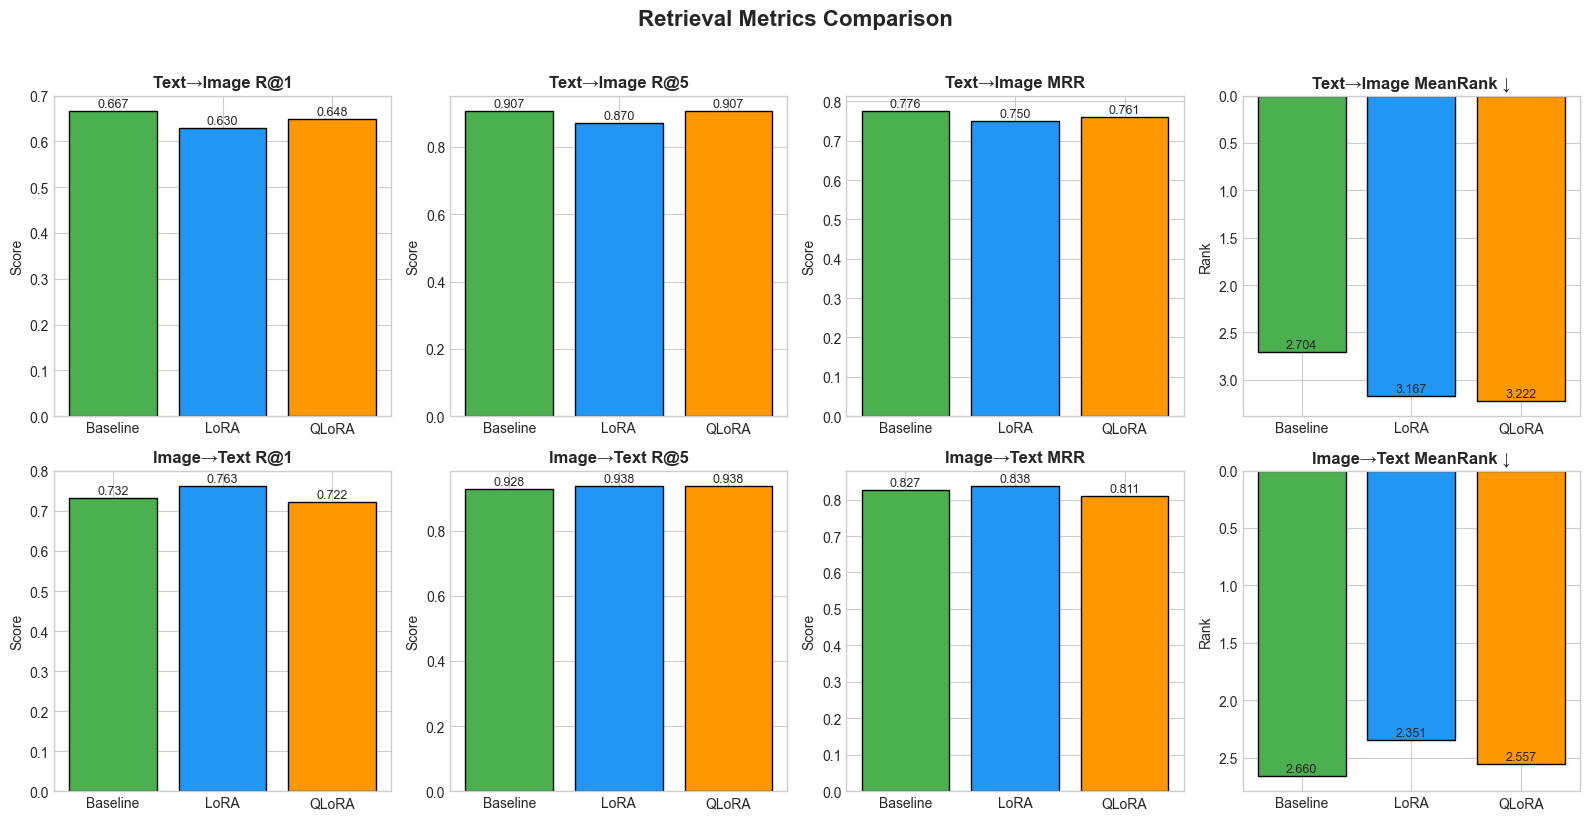

In [5]:
# Visualize retrieval metrics comparison
def plot_metrics_comparison(df: pd.DataFrame, experiments: Dict):
    color_map = {info["name"]: info["color"] for method, info in experiments.items() if "results" in info}
    methods = df["Method"].tolist()
    colors = [color_map.get(m, "#888") for m in methods]
    short_names = df["Short"].tolist() if "Short" in df.columns else methods
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    metrics_plot = [
        ("T2I R@1", "Text→Image R@1", axes[0,0]), ("T2I R@5", "Text→Image R@5", axes[0,1]),
        ("T2I MRR", "Text→Image MRR", axes[0,2]), ("T2I MeanRank", "Text→Image MeanRank ↓", axes[0,3]),
        ("I2T R@1", "Image→Text R@1", axes[1,0]), ("I2T R@5", "Image→Text R@5", axes[1,1]),
        ("I2T MRR", "Image→Text MRR", axes[1,2]), ("I2T MeanRank", "Image→Text MeanRank ↓", axes[1,3]),
    ]
    for col, title, ax in metrics_plot:
        if col not in df.columns:
            ax.set_visible(False)
            continue
        values = df[col].astype(float).values
        bars = ax.bar(short_names, values, color=colors, edgecolor="black", linewidth=1)
        ax.set_title(title, fontsize=12, fontweight="bold")
        ax.set_ylabel("Score" if "Rank" not in title else "Rank")
        for bar, val in zip(bars, values):
            ax.annotate(f'{val:.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                       xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)
        if "Rank" in title:
            ax.invert_yaxis()
    plt.suptitle("Retrieval Metrics Comparison", fontsize=16, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()

print("\n📊 RETRIEVAL METRICS VISUALIZATION")
plot_metrics_comparison(comparison_df, EXPERIMENTS)


## 4. Embedding Space Visualization

Visualize how the embedding space clusters before and after fine-tuning using:
- **t-SNE**: Non-linear dimensionality reduction
- **PCA**: Linear projection
- **UMAP**: Uniform manifold approximation


In [6]:
def generate_image_embeddings(model, processor, image_keys: List[str]) -> np.ndarray:
    embeddings = []
    model.eval()
    with torch.no_grad():
        for key in tqdm(image_keys, desc="Image embeddings"):
            img = load_image_from_minio(FINE_TUNING_BUCKET, key)
            if img is None:
                embeddings.append(np.zeros(512))
                continue
            inputs = processor(images=img, return_tensors="pt").to(DEVICE)
            emb = model.get_image_features(**inputs)
            emb = F.normalize(emb, dim=-1)
            embeddings.append(emb.cpu().numpy().flatten())
    return np.array(embeddings)

def generate_text_embeddings(model, processor, texts: List[str]) -> np.ndarray:
    embeddings = []
    model.eval()
    with torch.no_grad():
        for text in tqdm(texts, desc="Text embeddings"):
            inputs = processor(text=[text], return_tensors="pt", padding=True, truncation=True, max_length=77).to(DEVICE)
            emb = model.get_text_features(**inputs)
            emb = F.normalize(emb, dim=-1)
            embeddings.append(emb.cpu().numpy().flatten())
    return np.array(embeddings)

print("✓ Embedding generation functions defined")


✓ Embedding generation functions defined


In [7]:
# Load models and generate embeddings for visualization
MODEL_NAME = CONFIG.get("model", {}).get("name", "openai/clip-vit-base-patch32")
models_loaded = {}

# Clear GPU memory before loading models
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    import gc
    gc.collect()
    print(f"GPU memory cleared. Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB total")

# Sample test data for visualization (limit to avoid memory issues)
MAX_SAMPLES = min(50, len(test_df))
sample_df = test_df.sample(MAX_SAMPLES, random_state=RANDOM_SEED) if len(test_df) > MAX_SAMPLES else test_df
sample_images = sample_df["image_key"].dropna().astype(str).tolist()
sample_texts = sample_df["caption"].tolist()
sample_recipe_ids = sample_df["recipe_id"].tolist()

print(f"Generating embeddings for {len(sample_df)} samples...")

# Load baseline model
print("\n🔄 Loading baseline CLIP model...")
if not TRANSFORMERS_AVAILABLE:
    print("✗ transformers library not available - skipping model loading")
    print("  Install with: pip install transformers")
else:
    try:
        from transformers import CLIPModel, CLIPProcessor
        # Try GPU first, fall back to CPU if OOM
        try:
            if torch.cuda.is_available():
                torch.cuda.empty_cache()  # Clear any cached memory
            baseline_model = CLIPModel.from_pretrained(MODEL_NAME).to(DEVICE)
            print(f"✓ Baseline model loaded on {DEVICE}")
        except RuntimeError as cuda_err:
            if "CUDA out of memory" in str(cuda_err) or "out of memory" in str(cuda_err).lower():
                print(f"⚠ GPU out of memory, falling back to CPU...")
                baseline_model = CLIPModel.from_pretrained(MODEL_NAME).to("cpu")
                DEVICE = "cpu"  # Update device for subsequent operations
                print(f"✓ Baseline model loaded on CPU")
            else:
                raise cuda_err
        processor = CLIPProcessor.from_pretrained(MODEL_NAME)
        models_loaded["baseline"] = {"model": baseline_model, "processor": processor}
    except Exception as e:
        print(f"✗ Failed to load baseline: {e}")

# Generate baseline embeddings
if "baseline" in models_loaded:
    print("\n🔄 Generating baseline embeddings...")
    baseline_img_emb = generate_image_embeddings(models_loaded["baseline"]["model"], models_loaded["baseline"]["processor"], sample_images)
    baseline_txt_emb = generate_text_embeddings(models_loaded["baseline"]["model"], models_loaded["baseline"]["processor"], sample_texts)
    print(f"✓ Baseline embeddings: images={baseline_img_emb.shape}, texts={baseline_txt_emb.shape}")

# Check if LoRA adapter path exists
if "lora" in EXPERIMENTS and "results_key" in EXPERIMENTS["lora"]:
    lora_dir = str(Path(EXPERIMENTS["lora"]["results_key"]).parent)
    adapter_key = f"{lora_dir}/adapter"
    print(f"\n🔄 Checking LoRA adapter at: {adapter_key}/...")


GPU memory cleared. Available: 3.90 GB total
Generating embeddings for 50 samples...

🔄 Loading baseline CLIP model...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✓ Baseline model loaded on cuda

🔄 Generating baseline embeddings...


Text embeddings: 100%|██████████| 50/50 [00:01<00:00, 46.41it/s]

✓ Baseline embeddings: images=(50, 512), texts=(50, 512)

🔄 Checking LoRA adapter at: experiments/lora/run_lora_20260108_211822/adapter/...



📊 Applying t-SNE to baseline embeddings...


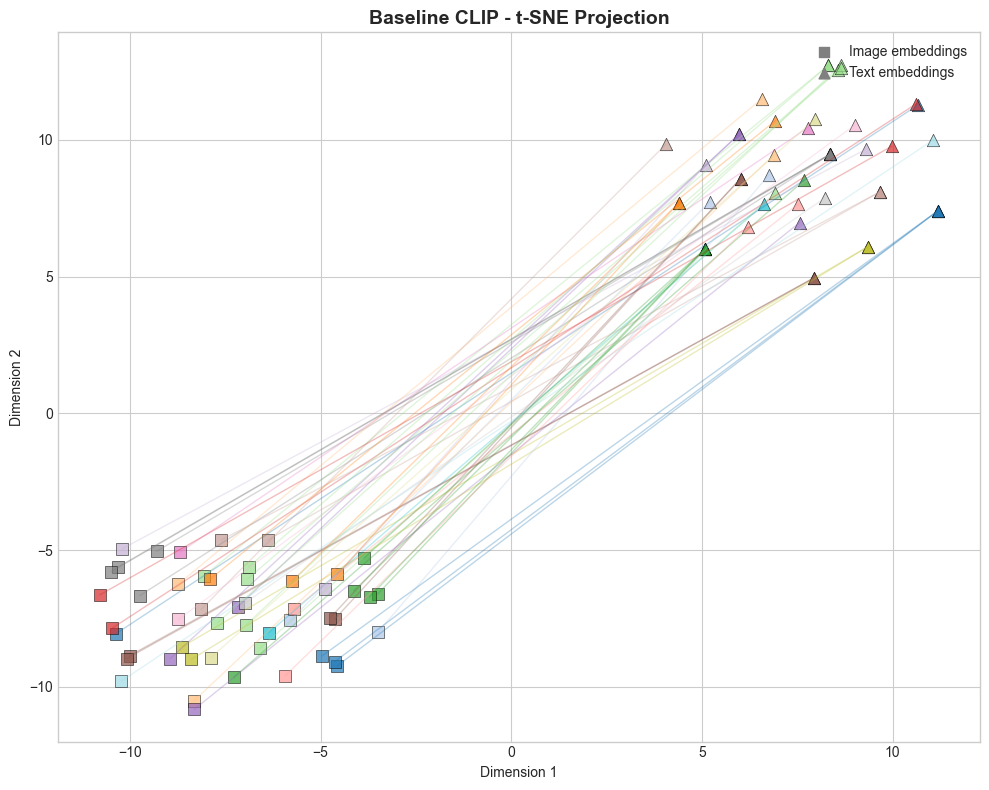


📊 Applying PCA to baseline embeddings...


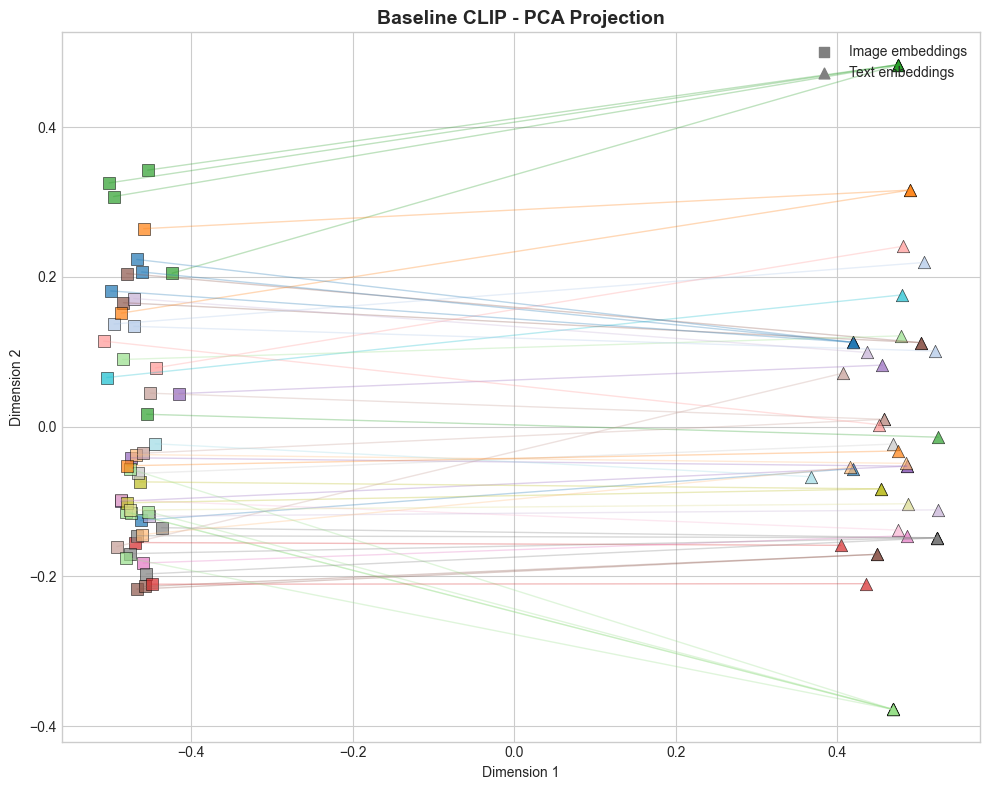


📊 Applying UMAP to baseline embeddings...


/home/didac/Desktop/upc/adsdb/adsdb-multimodal-food-data-management/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/didac/Desktop/upc/adsdb/adsdb-multimodal-food-data-management/venv/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


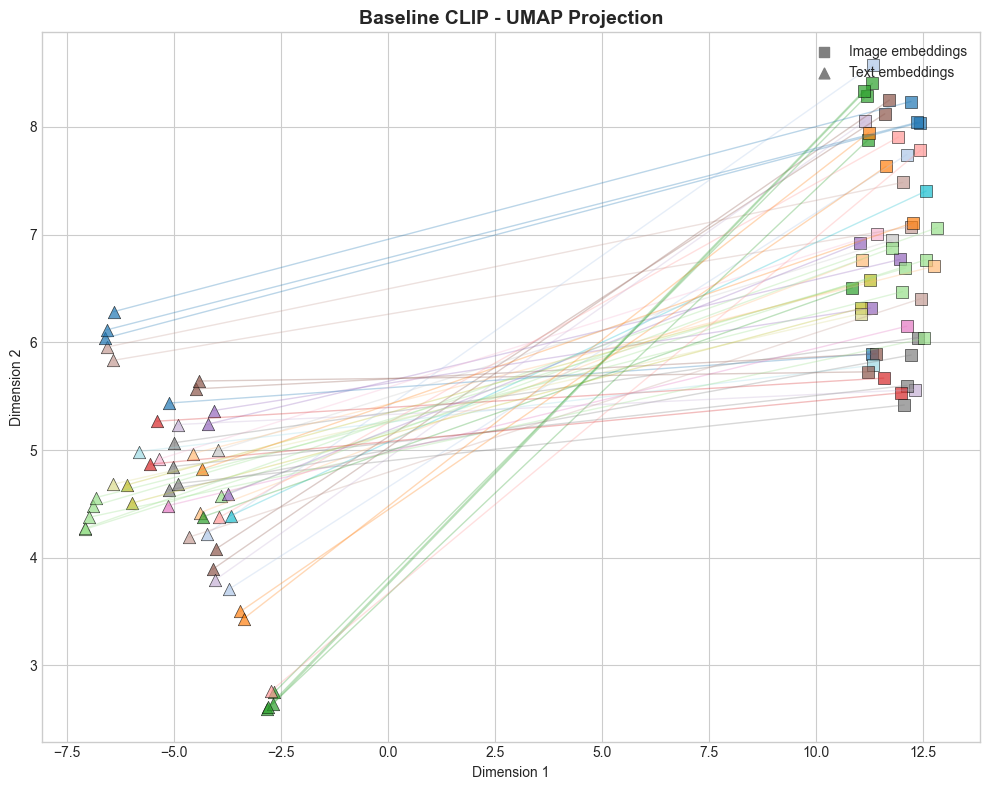

In [8]:
# Dimensionality reduction and visualization
def apply_reduction(embeddings: np.ndarray, method: str = "tsne") -> np.ndarray:
    if method == "tsne":
        perplexity = min(30, len(embeddings) - 1)
        reducer = TSNE(n_components=2, perplexity=perplexity, random_state=RANDOM_SEED, max_iter=1000)
    elif method == "pca":
        reducer = PCA(n_components=2, random_state=RANDOM_SEED)
    elif method == "umap" and UMAP_AVAILABLE:
        n_neighbors = min(15, len(embeddings) - 1)
        reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, random_state=RANDOM_SEED)
    else:
        return None
    return reducer.fit_transform(embeddings)

def plot_embedding_space(img_coords: np.ndarray, txt_coords: np.ndarray, recipe_ids: List, title: str):
    fig, ax = plt.subplots(figsize=(10, 8))
    unique_recipes = list(set(recipe_ids))
    colors = plt.cm.tab20(np.linspace(0, 1, min(20, len(unique_recipes))))
    recipe_to_color = {r: colors[i % len(colors)] for i, r in enumerate(unique_recipes)}
    
    for i, (img_pt, txt_pt, rid) in enumerate(zip(img_coords, txt_coords, recipe_ids)):
        c = recipe_to_color[rid]
        ax.scatter(img_pt[0], img_pt[1], c=[c], marker='s', s=80, alpha=0.7, edgecolor='black', linewidth=0.5)
        ax.scatter(txt_pt[0], txt_pt[1], c=[c], marker='^', s=80, alpha=0.7, edgecolor='black', linewidth=0.5)
        ax.plot([img_pt[0], txt_pt[0]], [img_pt[1], txt_pt[1]], c=c, alpha=0.3, linewidth=1)
    
    ax.scatter([], [], marker='s', c='gray', label='Image embeddings', s=60)
    ax.scatter([], [], marker='^', c='gray', label='Text embeddings', s=60)
    ax.legend(loc='upper right')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Dimension 1"); ax.set_ylabel("Dimension 2")
    plt.tight_layout()
    plt.show()

# Apply dimensionality reduction to baseline embeddings
if "baseline" in models_loaded:
    combined = np.vstack([baseline_img_emb, baseline_txt_emb])
    n = len(baseline_img_emb)
    
    # t-SNE
    print("\n📊 Applying t-SNE to baseline embeddings...")
    combined_tsne = apply_reduction(combined, "tsne")
    if combined_tsne is not None:
        plot_embedding_space(combined_tsne[:n], combined_tsne[n:], sample_recipe_ids, "Baseline CLIP - t-SNE Projection")
    
    # PCA
    print("\n📊 Applying PCA to baseline embeddings...")
    combined_pca = apply_reduction(combined, "pca")
    if combined_pca is not None:
        plot_embedding_space(combined_pca[:n], combined_pca[n:], sample_recipe_ids, "Baseline CLIP - PCA Projection")
    
    # UMAP (if available)
    if UMAP_AVAILABLE:
        print("\n📊 Applying UMAP to baseline embeddings...")
        combined_umap = apply_reduction(combined, "umap")
        if combined_umap is not None:
            plot_embedding_space(combined_umap[:n], combined_umap[n:], sample_recipe_ids, "Baseline CLIP - UMAP Projection")
    else:
        print("\n⚠ UMAP not available - install with: pip install umap-learn")


## 5. Retrieval Comparison (Before/After Fine-tuning)

Compare the top-5 retrieved images for the same text queries across models.


In [9]:
def compute_retrieval_for_query(model, processor, query_text: str, image_embeddings: np.ndarray, image_paths: List[str], top_k: int = 5):
    """Compute top-k image retrievals for a text query."""
    model.eval()
    with torch.no_grad():
        inputs = processor(text=[query_text], return_tensors="pt", padding=True, truncation=True, max_length=77).to(DEVICE)
        text_emb = model.get_text_features(**inputs)
        text_emb = F.normalize(text_emb, dim=-1).cpu().numpy()
    
    # Compute similarities
    similarities = (image_embeddings @ text_emb.T).flatten()
    top_indices = np.argsort(similarities)[::-1][:top_k]
    return [(image_paths[i], similarities[i]) for i in top_indices]

def plot_retrieval_comparison(query_text: str, correct_recipe_id: str, results_dict: Dict):
    """Plot side-by-side retrieval results from multiple models."""
    num_models = len(results_dict)
    fig, axes = plt.subplots(num_models, 5, figsize=(15, 3 * num_models))
    if num_models == 1:
        axes = [axes]
    
    for row, (model_name, results) in enumerate(results_dict.items()):
        for col, (img_path, sim) in enumerate(results[:5]):
            ax = axes[row][col]
            img = load_image_from_minio(FINE_TUNING_BUCKET, img_path)
            if img:
                ax.imshow(img)
                # Check if correct match
                is_correct = correct_recipe_id in img_path
                border_color = 'green' if is_correct else 'red'
                for spine in ax.spines.values():
                    spine.set_edgecolor(border_color)
                    spine.set_linewidth(3)
            ax.set_title(f"Sim: {sim:.3f}", fontsize=10)
            ax.axis('off')
            if col == 0:
                ax.set_ylabel(model_name, fontsize=12, fontweight='bold')
    
    plt.suptitle(f'Query: "{query_text[:60]}..."', fontsize=12, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

print("✓ Retrieval comparison functions defined")


✓ Retrieval comparison functions defined



📊 SAMPLE RETRIEVAL COMPARISONS
Note: Green border = correct match, Red border = incorrect match



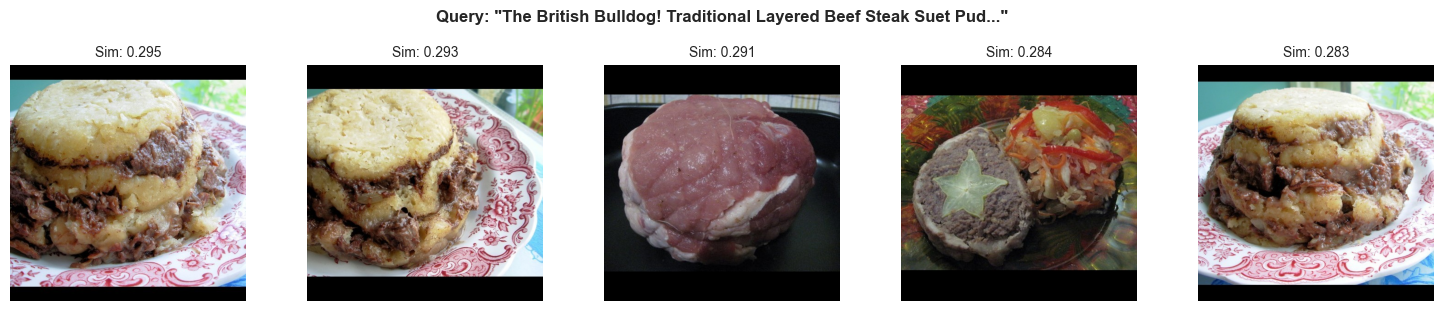

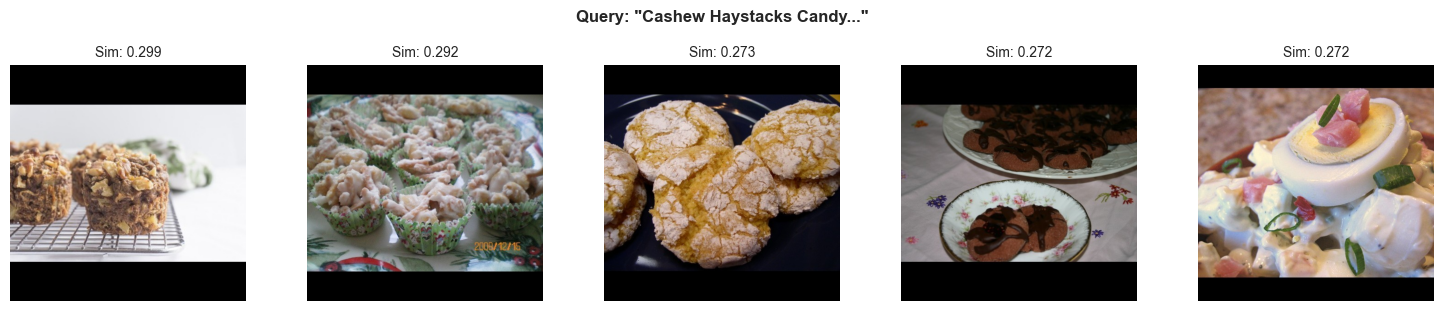

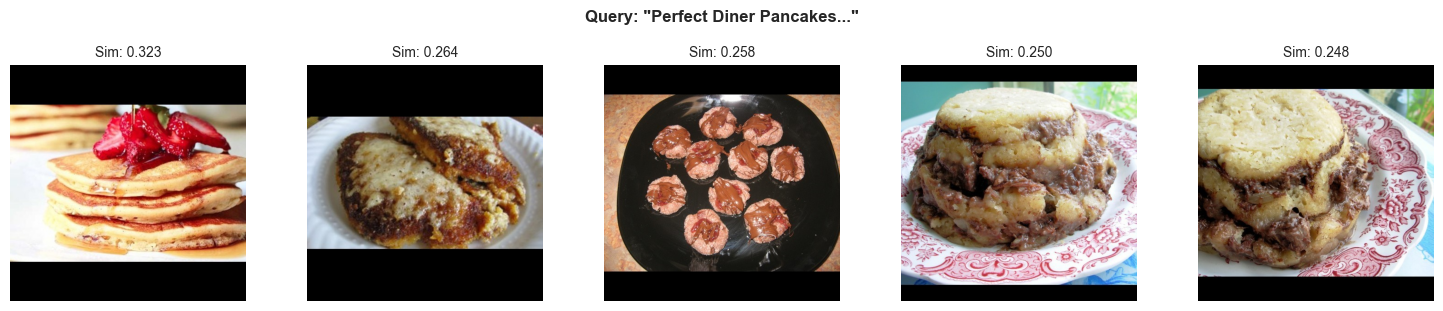

In [10]:
# Sample retrieval comparison using baseline model embeddings
if "baseline" in models_loaded and len(sample_df) > 0:
    print("\n📊 SAMPLE RETRIEVAL COMPARISONS")
    print("=" * 70)
    print("Note: Green border = correct match, Red border = incorrect match\n")
    
    # Select a few sample queries
    sample_queries = sample_df.sample(min(3, len(sample_df)), random_state=RANDOM_SEED)
    
    for idx, row in sample_queries.iterrows():
        query_text = row["caption"]
        correct_recipe = row["recipe_id"]
        
        # Get baseline retrieval
        results = compute_retrieval_for_query(
            models_loaded["baseline"]["model"],
            models_loaded["baseline"]["processor"],
            query_text,
            baseline_img_emb,
            sample_images,
            top_k=5
        )
        
        plot_retrieval_comparison(query_text, correct_recipe, {"Baseline": results})


## 6. Efficiency Analysis


EFFICIENCY METRICS COMPARISON

📊 Training Efficiency Metrics:


,Method,Training Time (s),Peak VRAM (MB),Trainable Params,Final Loss
0,Baseline,NaN,679.704102,151277313,NaN
1,LoRA,525.183212,902.530762,983041,0.036937
2,QLoRA,690.382060,417.551270,983041,0.084274


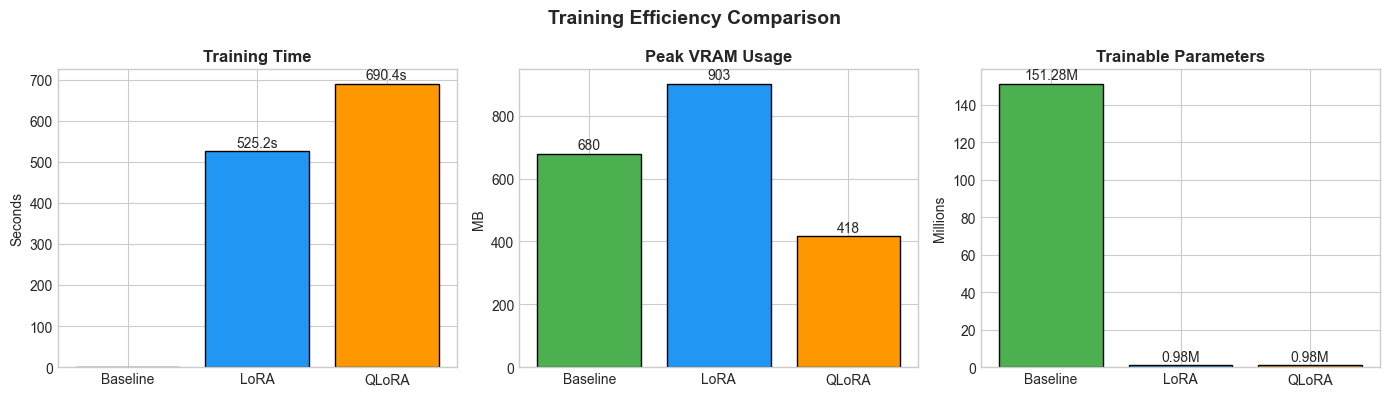

In [11]:
print("=" * 70)
print("EFFICIENCY METRICS COMPARISON")
print("=" * 70)

# Extract efficiency metrics
efficiency_data = []
for method, info in EXPERIMENTS.items():
    if "results" not in info:
        continue
    metrics = extract_metrics(info["results"])
    efficiency_data.append({
        "Method": info["short_name"],
        "Training Time (s)": metrics.get("Training Time (s)", "N/A"),
        "Peak VRAM (MB)": metrics.get("Peak VRAM (MB)", "N/A"),
        "Trainable Params": metrics.get("Trainable Params", "N/A"),
        "Final Loss": metrics.get("Final Loss", "N/A"),
    })

efficiency_df = pd.DataFrame(efficiency_data)
print("\n📊 Training Efficiency Metrics:")
display(efficiency_df)

# Plot efficiency comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
color_map = {info["short_name"]: info["color"] for method, info in EXPERIMENTS.items() if "results" in info}
methods = efficiency_df["Method"].tolist()
colors = [color_map.get(m, "#888") for m in methods]

# Training time
ax = axes[0]
values = pd.to_numeric(efficiency_df["Training Time (s)"], errors='coerce').fillna(0)
if values.sum() > 0:
    bars = ax.bar(methods, values, color=colors, edgecolor='black')
    ax.set_ylabel("Seconds"); ax.set_title("Training Time", fontweight='bold')
    for bar, val in zip(bars, values):
        if val > 0:
            ax.annotate(f'{val:.1f}s', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                       xytext=(0, 3), textcoords="offset points", ha='center')

# Peak VRAM
ax = axes[1]
values = pd.to_numeric(efficiency_df["Peak VRAM (MB)"], errors='coerce').fillna(0)
if values.sum() > 0:
    bars = ax.bar(methods, values, color=colors, edgecolor='black')
    ax.set_ylabel("MB"); ax.set_title("Peak VRAM Usage", fontweight='bold')
    for bar, val in zip(bars, values):
        if val > 0:
            ax.annotate(f'{val:.0f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                       xytext=(0, 3), textcoords="offset points", ha='center')

# Trainable parameters
ax = axes[2]
values = pd.to_numeric(efficiency_df["Trainable Params"], errors='coerce').fillna(0)
if values.sum() > 0:
    bars = ax.bar(methods, values / 1e6, color=colors, edgecolor='black')
    ax.set_ylabel("Millions"); ax.set_title("Trainable Parameters", fontweight='bold')
    for bar, val in zip(bars, values):
        if val > 0:
            ax.annotate(f'{val/1e6:.2f}M', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                       xytext=(0, 3), textcoords="offset points", ha='center')

plt.suptitle("Training Efficiency Comparison", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 7. Summary and Conclusions


In [12]:
print("=" * 70)
print("EXPERIMENT SUMMARY")
print("=" * 70)

# Summary table
summary_data = []
for method, info in EXPERIMENTS.items():
    if "results" not in info:
        summary_data.append({"Method": info["name"], "Status": "NOT LOADED"})
        continue
    metrics = extract_metrics(info["results"])
    summary_data.append({
        "Method": info["name"],
        "T2I R@1": f"{metrics.get('T2I R@1', 0):.4f}",
        "I2T R@1": f"{metrics.get('I2T R@1', 0):.4f}",
        "MRR (avg)": f"{(metrics.get('T2I MRR', 0) + metrics.get('I2T MRR', 0))/2:.4f}",
        "Training Time": f"{metrics.get('Training Time (s)', 'N/A')}s" if metrics.get('Training Time (s)') else "N/A",
        "Peak VRAM": f"{metrics.get('Peak VRAM (MB)', 'N/A')} MB" if metrics.get('Peak VRAM (MB)') else "N/A",
        "Status": "✓"
    })

print("\n📊 Key Metrics Summary:")
display(pd.DataFrame(summary_data))

# Hypothesis evaluation
print("\n" + "=" * 70)
print("HYPOTHESIS EVALUATION")
print("=" * 70)

baseline_loaded = "baseline" in EXPERIMENTS and "results" in EXPERIMENTS["baseline"]
lora_loaded = "lora" in EXPERIMENTS and "results" in EXPERIMENTS["lora"]
qlora_loaded = "qlora" in EXPERIMENTS and "results" in EXPERIMENTS["qlora"]

if baseline_loaded:
    b_metrics = extract_metrics(EXPERIMENTS["baseline"]["results"])

print("\n🔬 H1 (LoRA): Does fine-tuning improve text↔image alignment?")
if baseline_loaded and lora_loaded:
    l_metrics = extract_metrics(EXPERIMENTS["lora"]["results"])
    delta_r1 = l_metrics["T2I R@1"] - b_metrics["T2I R@1"]
    delta_mrr = l_metrics["T2I MRR"] - b_metrics["T2I MRR"]
    improved = delta_r1 > 0 or delta_mrr > 0
    print(f"   Baseline T2I R@1: {b_metrics['T2I R@1']:.4f} → LoRA: {l_metrics['T2I R@1']:.4f} (Δ={delta_r1:+.4f})")
    print(f"   Baseline T2I MRR: {b_metrics['T2I MRR']:.4f} → LoRA: {l_metrics['T2I MRR']:.4f} (Δ={delta_mrr:+.4f})")
    print(f"   Conclusion: {'✓ SUPPORTED' if improved else '✗ NOT SUPPORTED'} - Fine-tuning {'improved' if improved else 'did not improve'} alignment")
else:
    print("   ⚠ Cannot evaluate - missing baseline or LoRA results")

print("\n🔬 H2 (QLoRA): Does QLoRA achieve comparable performance with less memory?")
if lora_loaded and qlora_loaded:
    l_metrics = extract_metrics(EXPERIMENTS["lora"]["results"])
    q_metrics = extract_metrics(EXPERIMENTS["qlora"]["results"])
    
    perf_diff = abs(l_metrics["T2I R@1"] - q_metrics["T2I R@1"])
    comparable = perf_diff < 0.05  # Within 5%
    
    l_vram = l_metrics.get("Peak VRAM (MB)", 0) or 0
    q_vram = q_metrics.get("Peak VRAM (MB)", 0) or 0
    less_memory = q_vram < l_vram if (l_vram > 0 and q_vram > 0) else None
    
    print(f"   LoRA T2I R@1: {l_metrics['T2I R@1']:.4f}, QLoRA: {q_metrics['T2I R@1']:.4f} (diff={perf_diff:.4f})")
    if l_vram > 0 and q_vram > 0:
        print(f"   LoRA VRAM: {l_vram:.0f} MB, QLoRA: {q_vram:.0f} MB (savings={(l_vram-q_vram)/l_vram*100:.1f}%)")
    
    if comparable and less_memory:
        print("   Conclusion: ✓ SUPPORTED - QLoRA achieves comparable performance with less memory")
    elif comparable:
        print("   Conclusion: ⚠ PARTIAL - Performance comparable but memory comparison inconclusive")
    else:
        print("   Conclusion: ✗ NOT SUPPORTED - Significant performance difference detected")
else:
    print("   ⚠ Cannot evaluate - missing LoRA or QLoRA results")

print("\n" + "=" * 70)
print("Analysis complete!")
print("=" * 70)


EXPERIMENT SUMMARY

📊 Key Metrics Summary:


,Method,T2I R@1,I2T R@1,MRR (avg),Training Time,Peak VRAM,Status
0,M0: Baseline,0.6667,0.7320,0.8015,N/A,679.7041015625 MB,✓
1,M1: LoRA,0.6296,0.7629,0.7942,525.1832122802734s,902.53076171875 MB,✓
2,M2: QLoRA,0.6481,0.7216,0.7858,690.3820600509644s,417.55126953125 MB,✓



HYPOTHESIS EVALUATION

🔬 H1 (LoRA): Does fine-tuning improve text↔image alignment?
   Baseline T2I R@1: 0.6667 → LoRA: 0.6296 (Δ=-0.0370)
   Baseline T2I MRR: 0.7759 → LoRA: 0.7504 (Δ=-0.0254)
   Conclusion: ✗ NOT SUPPORTED - Fine-tuning did not improve alignment

🔬 H2 (QLoRA): Does QLoRA achieve comparable performance with less memory?
   LoRA T2I R@1: 0.6296, QLoRA: 0.6481 (diff=0.0185)
   LoRA VRAM: 903 MB, QLoRA: 418 MB (savings=53.7%)
   Conclusion: ✓ SUPPORTED - QLoRA achieves comparable performance with less memory

Analysis complete!
